# libraries

In [25]:
from palettes import vibrant, create_palette

import plotly.io as pio
import plotly.graph_objects as go

from dash import dcc, html, dash_table, Dash, Input, Output
import dash_bootstrap_components as dbc
from dash.dash_table.Format import Format, Group, Scheme, Symbol

from db_manager import MonthsTbl, SQL
from dash_inputs import *

import pandas as pd
import calendar
from datetime import datetime
import numpy as np

from jupyter_dash import JupyterDash

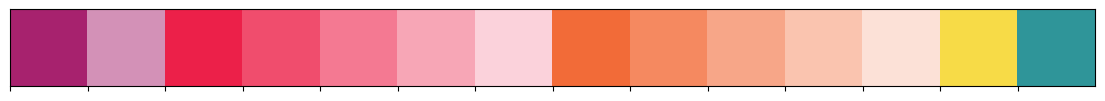

In [26]:
subcategory_palette = create_palette(vibrant)


money = Format(scheme=Scheme.fixed, precision=2,
               group=Group.yes, groups=3, group_delimiter=',',
               symbol=Symbol.yes, symbol_prefix=u'£')

# MONTHLY DASHBOARD

## 1. TITLE AND MONTH SELECTION

In [27]:
def monthly_title():

    db = SQL()

    table = Table(MonthsTbl.__tablename__, MonthsTbl.metadata)
    with db.engine.connect() as conn:
        df = pd.read_sql(sql=select(table), con=conn)
    months = df.sort_values('Date', ascending=False).id.unique()

    return html.Div([
        html.H1(id='month_title',
                children='Monthly Spending'),
        dcc.Dropdown(id='month_selection',
                     options=months,
                     # placeholder="Select a month",
                     value=months[0]
                     )
    ])

## 2. INCOME SUMMARY

In [28]:
def income_summary():
    return dcc.Graph(id='income', figure={})

In [29]:
def _update_income_summary(month_id):

    income = income_table(month_id)
    paycheck = income.set_index('Type').loc['Paycheck', 'Amount']

    taxes = income.Amount.sum() - paycheck
    taxes_str = ''
    for idx, row in income.iterrows():
        taxes_str += f'{row.Type}: £{abs(row.Amount):.2f},<br>'

    summary, _, monthly_spending = summary_table(month_id, total_row=False)

    df_budget = query_db('budget', month_id)
    bills = -df_budget.loc[df_budget.Category=='Bills', 'Budget'].sum()/100

    fig = go.Figure()

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=paycheck,
            title={'text': 'paycheck', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},
            delta={'position': 'right', 'reference': 0, 'prefix': '£', 'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.8, 0.9]}))

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=abs(taxes),
            title={'text': 'taxes', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},
            delta={'position': 'right', 'reference': -(paycheck + 2 * taxes), 'prefix': '£', 'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.55, 0.65]}))

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=abs(bills),
            title={'text': 'bills', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},
            delta={'position': 'right', 'reference': -(paycheck + taxes + 2 * bills), 'prefix': '£',
                   'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.3, 0.4]}))

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=abs(monthly_spending),
            title={'text': 'spending', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},  # font
            delta={'position': 'right', 'reference': -(paycheck + taxes + bills + 2 * monthly_spending), 'prefix': '£',
                   'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.05, 0.15]}))

    fig.add_annotation(x=0.49, y=0.6,
                       text='               ',
                       hovertext=taxes_str,
                       showarrow=False)

    fig.update_layout(height=340,
                      margin=dict(t=5, l=5, r=5, b=5)
                      )

    return fig

## 3. INVESTMENTS SUMMARY

In [30]:
def investments_summary():
    return dcc.Graph(id='investments', figure={})

In [31]:
def _update_investments_summary(month_id):

    dt_month_id_prev = datetime.strptime(month_id.lower(), '%b %y') - pd.DateOffset(months=1)
    month_id_prev = datetime.strftime(dt_month_id_prev, '%b %y').upper()

    _, liquidity = accounts_table(month_id)
    _, liquidity_prev = accounts_table(month_id_prev)

    inv_var, inv_fix, net_worth = investment_tables(month_id, liquidity)
    inv_var_prev, inv_fix_prev, net_worth_prev = investment_tables(month_id_prev, liquidity)

    fig = go.Figure()

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=liquidity,
            title={'text': 'liquidity', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},
            delta={'position': 'right', 'reference': liquidity_prev, 'prefix': '£', 'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.8, 0.9]}))

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=inv_fix.Amount.sum(),
            title={'text': 'fixed investments', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},
            delta={'position': 'right', 'reference': inv_fix_prev.Amount.sum(), 'prefix': '£', 'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.55, 0.65]}))

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=inv_var.Value.sum(),
            title={'text': 'variable investments', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},
            delta={'position': 'right', 'reference': inv_var_prev.Value.sum(), 'prefix': '£', 'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.3, 0.4]}))

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=net_worth,
            title={'text': 'net worth', 'align': 'left', 'font': {'size': 20}},
            number={'prefix': '£', 'valueformat': ',.2f'},  # font
            delta={'position': 'right', 'reference': net_worth_prev, 'prefix': '£', 'valueformat': ',.2f'},
            domain={'x': [0.1, 0.9], 'y': [0.05, 0.15]}))

    fig.update_layout(height=340,
                      margin=dict(t=5, l=5, r=5, b=5), )

    return fig

## 4. BAR CHART OF SPENDING

In [32]:
def bar_chart():
    return html.Div([
        dbc.Row([
            dbc.Col([
                dcc.RadioItems(id='bar_plot_radio_item',
                               options=[{'label': 'Category ', 'value': 'Category'},
                                        {'label': 'Subategory ', 'value': 'Subcategory'}],
                               value='Subcategory',
                               inline=True),
                    ], width=6),
            dbc.Col([
                dcc.Checklist(id='bar_plot_checklist',
                              options=[{'label': 'Hide Empty', 'value': True}],
                              value=[True]),
                    ], width=6),
            ]),

            dcc.Graph(figure={},
                      id='bar_plot'),
            # TODO: html.H6('This plot excludes the categories income and bills')
    ])

In [33]:
def _update_bar_chart(sub_category, hide_zeros, month_id):

    df, _, _ = summary_table(month_id, total_row=False)
    df = df[~df.Subcategory.isin(['Income', 'Bills'])]
    df.Total = -df.Total

    if hide_zeros:
        df = df[df.Total != 0]

    bar_fig = go.Figure(data=[
        go.Bar(name='Total',
               x=df[sub_category],
               y=df.Total,
               # TODO: how can I get it display subcategories in hovertemplate when grouped by category?
               # TODO: how can I add category total  in hovertemplate when grouped by category? Do this with a scatterplot?
               hovertemplate='%{x}<br>Spent: £%{y:.2f}',
               marker=dict(color=df["Subcategory"].apply(lambda x: subcategory_palette[x])),
               showlegend=False,
               # TODO: display diff to quantify how under/over budget we are (color coded if possible)
               # texttemplate='%{text:.2f}',
               # textposition='outside'
               ),
        go.Bar(name='Budget',
               x=df[sub_category],
               y=df.Budget,
               marker=dict(color='#D3D3D3'),
               hovertemplate='%{x}<br>Budget: £%{y:.2f}')
    ])

    bar_fig.update_layout(barmode='group',
                          legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99),
                          margin=dict(t=5, l=5, r=5, b=2),
                          height=350)

    bar_fig.update_yaxes(tickprefix='£')
    bar_fig.update_xaxes(tickangle=45)

    return bar_fig

## 5. ALL SPENDING TABLE

In [34]:
def all_spending_table():
    return dash_table.DataTable(
                id='all_spending_table',
                # data=spending.to_dict('records'),
                fixed_rows={'headers': True},
                style_table={'height': 150},
                # TODO: reduce row height
                # css=[{"selector": ".dash-spreadsheet tr th", "rule": "height: 20px;"},  # set height of header
                #      {"selector": ".dash-spreadsheet tr td", "rule": "height: 10px;"}],  # set height of body rows
                columns=[
                    {'id':'Date', 'name':'Date'},
                    {'id':'Subcategory', 'name':'Subcategory'},
                    {'id':'Name', 'name':'Name'},
                    {'id':'Description', 'name':'Description'},
                    {'id':'In', 'name':'In', 'type':'numeric', 'format':money},
                    {'id':'Out', 'name':'Out', 'type':'numeric', 'format':money},
                    {'id':'Balance', 'name':'Balance', 'type':'numeric', 'format':money}],
                sort_action='native',
                style_cell={'overflow': 'hidden',
                            'textOverflow': 'ellipsis',
                            'maxWidth': 0,
                            'font_size': '15px'},
                #tooltip_data=[{column: {'value': str(value), 'type': 'markdown'} for column, value in row.items() if column in ['Description', 'Name']}
                #              for row in spending.to_dict('records')],
                style_cell_conditional=[{'if': {'column_id': 'Date'}, 'width': '8%', 'textAlign':'left'},
                                        {'if': {'column_id': 'Subcategory'},'width': '15%', 'textAlign':'left'},
                                        {'if': {'column_id': 'Name'},'width': '16%', 'textAlign':'left'},
                                        {'if': {'column_id': 'Description'},'width': '26%', 'textAlign':'left'},
                                        {'if': {'column_id': 'In'},'width': '11%'},
                                        {'if': {'column_id': 'Out'},'width': '11%'},
                                        {'if': {'column_id': 'Balance'},'width': '13%'}],
                style_data_conditional=[{'if': {'filter_query': '{In} > 0', 'column_id':'In'}, 'color':'green'},
                                        {'if': {'filter_query': '{Out} > 0', 'column_id':'Out'}, 'color':'red'}],
            )

In [35]:
def _update_all_spending_table(month_id):
    spending = spending_table(month_id, dd_mm=True)
    return spending.to_dict('records')

## 6. SPENDING TIMELINE CHART

In [36]:
def timeline_chart():
    return html.Div([
        dcc.Graph(id='timeline_chart',
                  figure={}),
        # TODO: html.H6('This plot excludes subcategories transfers and bills')
    ])

In [37]:
def _update_timeline_chart(month_id):

    df = spending_table(month_id, dd_mm=False)

    _, monthly_budget, _ = summary_table(month_id, total_row=True)

    start_d = df.Date[0]
    weekday, month_length = calendar.monthrange(start_d.year, start_d.month)

    dates = [datetime(start_d.year, start_d.month, day, 0, 0) for day in range(1, month_length + 1)]
    dates.append(datetime(start_d.year, start_d.month, month_length, 23, 59))

    daily_spend = monthly_budget / (len(dates) - 1)

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(name='Spending',
                   x=df.Date,
                   y=df.Balance,
                   hovertemplate='£%{y:.2f}'))

    fig.add_trace(
        go.Scatter(name='Budget',
                   x=dates,
                   y=np.arange(monthly_budget, -daily_spend, -daily_spend),
                   line={'color': 'green', 'dash': 'dash'},
                   hovertemplate='£%{y:.2f}'
                   ))

    if df.Balance.iloc[-1] >= 0:
        fig.add_annotation(x=dates[-3], y=monthly_budget * 0.9,
                           text="Left to spend:",
                           showarrow=False)
        fig.add_annotation(x=dates[-3], y=monthly_budget * 0.8,
                           text=f'£{df.Balance.iloc[-1]:.2f}',
                           showarrow=False)
    else:
        fig.add_annotation(x=dates[-3], y=monthly_budget * 0.9,
                           text="Over budget",
                           showarrow=False)
        fig.add_annotation(x=dates[-3], y=monthly_budget * 0.8,
                           text=f'-£{-df.Balance.iloc[-1]:.2f}',
                           showarrow=False)

    fig.update_layout(hovermode='x',
                      showlegend=False,
                      margin=dict(t=5, l=5, r=5, b=5),
                      height=281)

    fig.update_yaxes(range=[df.Balance.min(), monthly_budget + 5],
                     tickmode='array',
                     tickvals=[0, monthly_budget],
                     showgrid=False,
                     tickprefix='£')

    fig.update_xaxes(tickmode='array',
                     tickvals=[dates[0], dates[-1]])

    return fig

## 7. SUNBURST CHART

In [38]:
def sunburst_chart():
    return html.Div([
        dcc.RadioItems(id='sunburst_radio_item',
                       options=[{'label':'Spending', 'value':'Total'},
                                {'label':'Budget', 'value':'Budget'}],
                       value='Total',
                       inline=True),
        dcc.Graph(id='sunburst',
                  figure={}),
        # TODO: html.H6('This plot excludes the categories income and bills')
    ])

In [39]:
def _update_sunburst_chart(spend_budget, month_id):

    df, monthly_budget, monthly_spending = summary_table(month_id, total_row=False)
    df = df[~df.Subcategory.isin(['Income', 'Bills'])]
    df.Total = -df.Total

    labels = ['Total']
    parents = ['']
    if spend_budget == 'Total':
        values = [monthly_spending * -1]
    else:
        values = [monthly_budget]

    for cat in df.Category.unique():
        labels.append(cat + ' ')
        parents.append('Total')
        values.append(df[df.Category == cat][spend_budget].sum())

        if cat not in ['Holidays', 'Entertainment']:
            for subcat in df[df.Category == cat].Subcategory.unique():
                labels.append(subcat)
                parents.append(cat + ' ')
                values.append(df[df.Subcategory == subcat][spend_budget].sum())

    # Create sunburst plot
    sunburst = go.Figure(
        go.Sunburst(
            name='Sunburst',
            labels=labels,
            parents=parents,
            values=values,
            branchvalues='total',  # not column name Total
            # TODO can I add % of total spend to the hover? So it can double as a pie chart
            # hovertemplate='%{label}<br>£%{value:.2f} (%{value/values[0]}%)',
            hovertemplate='%{label}<br>£%{value:.2f}',
            marker=dict(colors=pd.Series(labels).apply(lambda x: subcategory_palette[x]))
        )
    )

    # Set plot title
    sunburst.update_layout(margin=dict(t=5, l=0, r=0, b=5),
                           height=350)

    return sunburst

## 8. SPENDING BY SUBCATEGORY TABLE

In [40]:
def spending_by_subcategory():
    return dash_table.DataTable(
        id='spending_by_subcategory_table',
        # data=df.drop('Category', axis=1).to_dict('records'),
        columns=[{'id':'Subcategory', 'name':'Subcategory'},
                 {'id':'In', 'name':'In', 'type':'numeric', 'format': money},
                 {'id':'Out', 'name':'Out', 'type':'numeric', 'format': money},
                 {'id':'Total', 'name':'Total', 'type':'numeric', 'format': money},
                 {'id':'Budget', 'name':'Budget', 'type':'numeric', 'format': money},
                 {'id':'Diff.', 'name':'Diff.', 'type':'numeric', 'format': money}],
        style_cell={'font_size': '15px'},
        style_cell_conditional=[{'if': {'column_id': 'Subcategory'}, 'width': '25%', 'textAlign':'left'},
                                {'if': {'column_id': 'In'},'width': '15%'},
                                {'if': {'column_id': 'Out'},'width': '15%'},
                                {'if': {'column_id': 'Total'},'width': '15%'},
                                {'if': {'column_id': 'Budget'},'width': '15%'},
                                {'if': {'column_id': 'Diff.'},'width': '15%'}],
        style_data_conditional=[{'if': {'filter_query': '{Diff.} > 0', 'column_id':'Diff.'}, 'color':'green'},
                                {'if': {'filter_query': '{Diff.} < 0', 'column_id':'Diff.'}, 'color':'red'},
                                # there must be a way to do this with a colour mapping
                                {'if': {'filter_query': '{Subcategory} = Income', 'column_id':'Subcategory'}, 'color':'green'},
                                #{'if': {'filter_query': '{Subcategory} = Transport', 'column_id':'Subcategory'}, 'color':subcategory_palette['Transport']},
                                #{'if': {'filter_query': '{Subcategory} = Car', 'column_id':'Subcategory'}, 'color':subcategory_palette['Car']},
                                #{'if': {'filter_query': '{Subcategory} = Groceries', 'column_id':'Subcategory'}, 'color':subcategory_palette['Groceries']},
                                #{'if': {'filter_query': '{Subcategory} = Snacks', 'column_id':'Subcategory'}, 'color':subcategory_palette['Snacks']},
                                #{'if': {'filter_query': '{Subcategory} = Lunch', 'column_id':'Subcategory'}, 'color':subcategory_palette['Lunch']},
                                #{'if': {'filter_query': '{Subcategory} = Eating out', 'column_id':'Subcategory'}, 'color':subcategory_palette['Eating out']},
                                #{'if': {'filter_query': '{Subcategory} = Alcohol', 'column_id':'Subcategory'}, 'color':subcategory_palette['Alcohol']},
                                #{'if': {'filter_query': '{Subcategory} = Shopping', 'column_id':'Subcategory'}, 'color':subcategory_palette['Shopping']},
                                #{'if': {'filter_query': '{Subcategory} = Clothes', 'column_id':'Subcategory'}, 'color':subcategory_palette['Clothes']},
                                #{'if': {'filter_query': '{Subcategory} = Electronics', 'column_id':'Subcategory'}, 'color':subcategory_palette['Electronics']},
                                #{'if': {'filter_query': '{Subcategory} = Personal care', 'column_id':'Subcategory'}, 'color':subcategory_palette['Personal care']},
                                #{'if': {'filter_query': '{Subcategory} = Gifts', 'column_id':'Subcategory'}, 'color':subcategory_palette['Gifts']},
                                #{'if': {'filter_query': '{Subcategory} = Entertainment', 'column_id':'Subcategory'}, 'color':subcategory_palette['Entertainment']},
                                #{'if': {'filter_query': '{Subcategory} = Holidays', 'column_id':'Subcategory'}, 'color':subcategory_palette['Holidays']},
                                #{'if': {'filter_query': '{Subcategory} = TOTAL', 'column_id':'Subcategory'}, 'color':'black'},
                                ],
        page_size=20)

In [41]:
def _update_spending_by_subcategory(month_id):
    df, _, _ = summary_table(month_id, total_row=False)
    return df.drop('Category', axis=1).to_dict('records')

# MONTHLY DASHBOARD

In [42]:
def monthly_dashboard():
    return html.Div([
        dbc.Row([

            dbc.Col([
                # 1. MONTH TITLE
                dbc.Card(dbc.CardBody(html.Div([monthly_title()])), style={"margin-bottom": "1rem", "margin-top": "1rem", "margin-left": "1rem"}),
                # 2. INCOME SUMMARY
                dbc.Card(dbc.CardBody(html.Div([income_summary()])), style={"margin-bottom": "1rem", "margin-left": "1rem"}),
                # 3. INVESTMENTS SUMMARY
                dbc.Card(dbc.CardBody(html.Div([investments_summary()])), style={"margin-bottom": "1rem", "margin-left": "1rem"}),
            ], width=3),

            dbc.Col([
                # 4. SPENDING BAR PLOT
                dbc.Card(dbc.CardBody([html.Div([bar_chart()])]), style={"margin-bottom": "1rem", "margin-top": "1rem"}),
                # 5. ALL SPENDING DATA TABLE
                dbc.Card(html.Div([all_spending_table()]), style={"margin-bottom": "1rem"}),
                # 6. SPENDING OVER THE MONTH
                dbc.Card(dbc.CardBody(html.Div([timeline_chart()])), style={"margin-bottom": "1rem"})
            ], width=5),

            dbc.Col([
                # 7. SUNBURST PLOT OF SPENDING/BUDGET
                dbc.Card(dbc.CardBody(html.Div([sunburst_chart()])), style={"margin-bottom": "1rem", "margin-right": "1rem", "margin-top": "1rem"}),
                # 8. SPENDING BY SUBCATEGORY
                dbc.Card(html.Div([spending_by_subcategory()]), style={"margin-bottom": "1rem", "margin-right": "1rem"}),
            ], width=4),
        ]),
    ])


In [43]:
def historic_dashboard():
    return html.Div([
        html.H1('Historic Dashboard: Work in Progress')
    ])

In [44]:
def investments_dashboard():
    return html.Div([
        html.H1('Investments Dashboard: Work in Progress')
    ])

In [45]:
def add_tabs():
    return dbc.Row([
        dcc.Tabs(id='dashboard_selection_tabs',
                 value='monthly_tab',
                 children=[
                     dcc.Tab(label='Monthly', value='monthly_tab'),
                     dcc.Tab(label='Historic', value='historic_tab'),
                     dcc.Tab(label='Investments', value='investments_tab')]
                 )
    ])

In [46]:
def _tab_selection(tab):
    if tab == 'monthly_tab':
        return monthly_dashboard()
    elif tab == 'historic_tab':
        return historic_dashboard()
    elif tab == 'investments_tab':
        return investments_dashboard()

In [47]:
def my_dashboard():
    pio.templates.default = "plotly"

    app = JupyterDash(external_stylesheets=[dbc.themes.COSMO], suppress_callback_exceptions=True)
    # suppressed callback exceptions because ids of plots aren't give inn app.layout due to being called from add_tabs() function.
    # app = Dash(external_stylesheets=[dbc.themes.COSMO])

    app.layout = html.Div([
        add_tabs(),
        html.Div(id='selected_tab'),
        ],
    className='dbc')

    @app.callback(
        Output('selected_tab', 'children'),
        Input('dashboard_selection_tabs', 'value')
    )
    def tab_selection(tab):
        return _tab_selection(tab)

    # 2. INCOME SUMMARY
    @app.callback(
        Output(component_id='income', component_property='figure'),
        Input(component_id='month_selection', component_property='value')
    )
    def update_income_summary(month_id):
        return _update_income_summary(month_id)

    # 3. INVESTMENTS SUMMARY
    @app.callback(
        Output(component_id='investments', component_property='figure'),
        Input(component_id='month_selection', component_property='value')
    )
    def update_investments_summary(month_id):
        return _update_investments_summary(month_id)

    # 4. BAR CHART OF SPENDING
    @app.callback(
        Output(component_id='bar_plot', component_property='figure'),
        Input(component_id='bar_plot_radio_item', component_property='value'),
        Input(component_id='bar_plot_checklist', component_property='value'),
        Input(component_id='month_selection', component_property='value')
    )
    def update_bar_plot(sub_category, hide_zeros, month_id):
        return _update_bar_chart(sub_category, hide_zeros, month_id)

    # 5. ALL SPENDING DATA TABLE
    @app.callback(
        Output(component_id='all_spending_table', component_property='data'),
        Input(component_id='month_selection', component_property='value')
    )
    def update_all_spending_table(month_id):
        return _update_all_spending_table(month_id)

    # 6. SPENDING TIMELINE CHART
    @app.callback(
        Output(component_id='timeline_chart', component_property='figure'),
        Input(component_id='month_selection', component_property='value')
    )
    def update_timeline_chart(month_id):
        return _update_timeline_chart(month_id)

    # 7. SUNBURST CHART

    @app.callback(
        Output(component_id='sunburst', component_property='figure'),
        Input(component_id='sunburst_radio_item', component_property='value'),
        Input(component_id='month_selection', component_property='value')
    )
    def update_sunburst_plot(spend_budget, month_id):
        return _update_sunburst_chart(spend_budget, month_id)

    # 8. SPENDING BY SUBCATEGORY TABLE
    @app.callback(
        Output(component_id='spending_by_subcategory_table', component_property='data'),
        Input(component_id='month_selection', component_property='value')
    )
    def update_spending_by_subcategory(month_id):
        return _update_spending_by_subcategory(month_id)

    app.run_server()

In [48]:
my_dashboard()

Dash is running on http://127.0.0.1:8050/



2023-08-04 12:09:50 LT-0032 dash.dash[28208] INFO Dash is running on http://127.0.0.1:8050/



Dash app running on http://127.0.0.1:8050/
